#### Gather data, determine the method of data collection and provenance of the data (1 point)

## Data Collection & Provenance

**Competition:** https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview

### **Goal:** The goal is to detect nasty comments (toxic, obscene, threats, etc.) so online convos stay civil.It is a Multi-label text classification.

* **Why:** Online abuse drives people away from the platforms. Automatic filters help mods keep discussions healthy.  

## Data  
* **Source:** Wikipedia talk-page comments (63 M total, but ~160 k rows in the public train split).  
* **Files in `/data`:**  
  * `train.csv` – text + 6 binary targets  
  * `test.csv`  – text only (labels hidden)  
  * `sample_submission.csv` – template for Kaggle upload  
| column name | dtype | what it represents | notes / possible action |
|-------------|-------|--------------------|-------------------------|
| `id` | object | unique row identifier | drop before modelling |
| `comment_text` | object | raw Wikipedia comment | needs text cleaning and tokenisation |
| `toxic` | int (0/1) | general toxicity flag | target label |
| `severe_toxic` | int | stronger form of `toxic` | target label |
| `obscene` | int | contains profanity | target label |
| `threat` | int | violent threat | highly imbalanced target |
| `insult` | int | personal insult | target label |
| `identity_hate` | int | slur against protected group | target label |


In [30]:
pip install upsetplot

Note: you may need to restart the kernel to use updated packages.


In [31]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Conv1D,GlobalMaxPooling1D, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from scipy.sparse import hstack
import re
import string
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis (EDA)

In [32]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [4]:
ROOT = "/kaggle/input/jigsaw-toxic-comment-classification-challenge"
df         = pd.read_csv(f"{ROOT}/train.csv.zip",         compression="zip")
test          = pd.read_csv(f"{ROOT}/test.csv.zip",          compression="zip")
submission    = pd.read_csv(f"{ROOT}/sample_submission.csv.zip", compression="zip")
test_labels   = pd.read_csv(f"{ROOT}/test_labels.csv.zip",   compression="zip")

df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [6]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [7]:
df.shape

(159571, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


* There is no mismatch between data types and data observations

In [9]:
df[label_cols].sum().sort_values()

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64

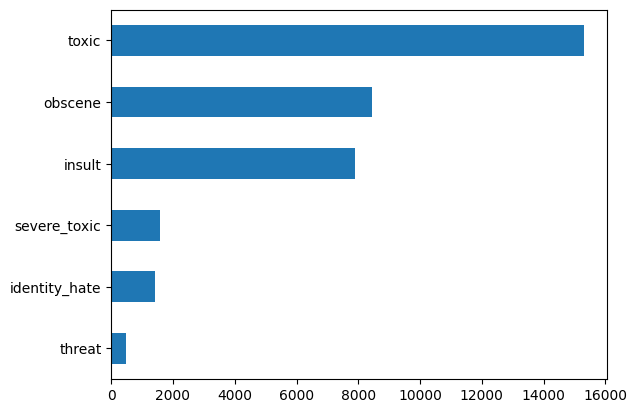

In [10]:
label_cols = ['toxic','severe_toxic','obscene',
              'threat','insult','identity_hate']
df[label_cols].sum().sort_values().plot.barh()
plt.show()

* Majority of labels are toxic, insult and obscene! We less observation of identity have and threat or severe toxic comments which kinda reflects the real world situation. But of course this is a imbalanced label representation. Since we dont have anymore data we cant do nothing about it now!

<Axes: ylabel='count'>

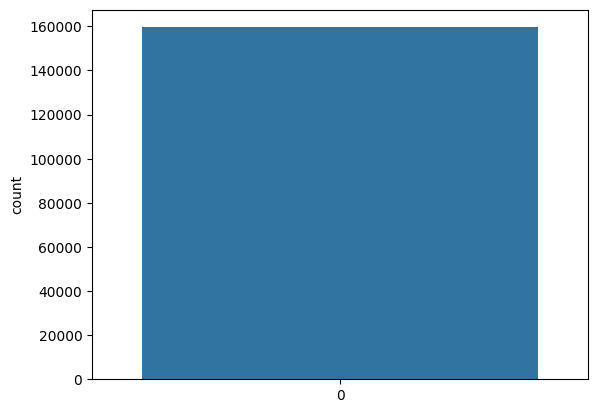

In [11]:
df['num_labels'] = df[label_cols].sum(axis=1)
sns.countplot(df['num_labels'])

<Axes: >

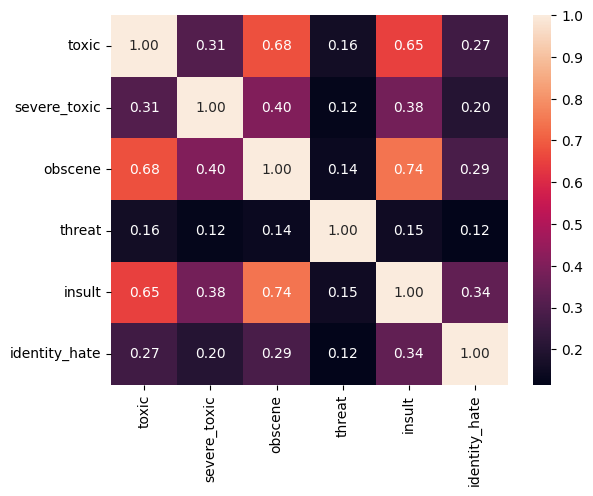

In [12]:
corr = df[label_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f")

* The correlation matrix explains a lot, we can see several class have high positive correlation!
* toxic, obscene, and insult are strongly correlated, so a comment marked as obscene is very likely to also be marked as toxic and/or insulting.
* So, not all toxic comments are severely toxic or identity-hating, but there’s still some connection.

* Threats seem to be a distinct type of toxic behavior. They don’t often overlap with other categories.

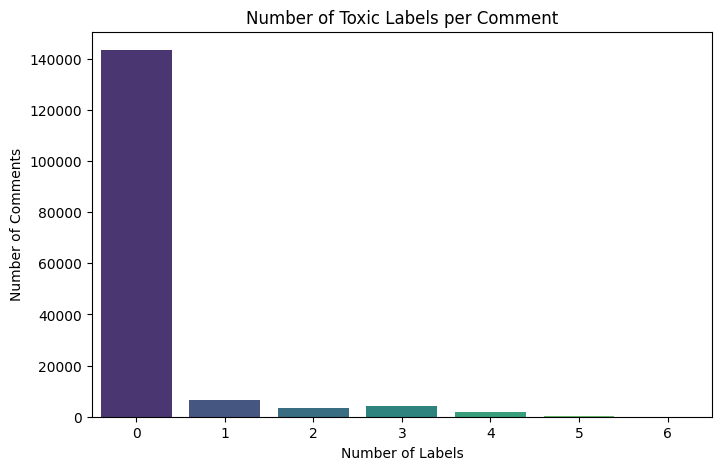

In [13]:
train =df.copy()
train['num_labels'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)


plt.figure(figsize=(8,5))
sns.countplot(x='num_labels', data=train, palette='viridis')

plt.title('Number of Toxic Labels per Comment')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Comments')
plt.xticks(ticks=range(0, 7))  # Because max can be 6
plt.show()

<Figure size 1200x600 with 0 Axes>

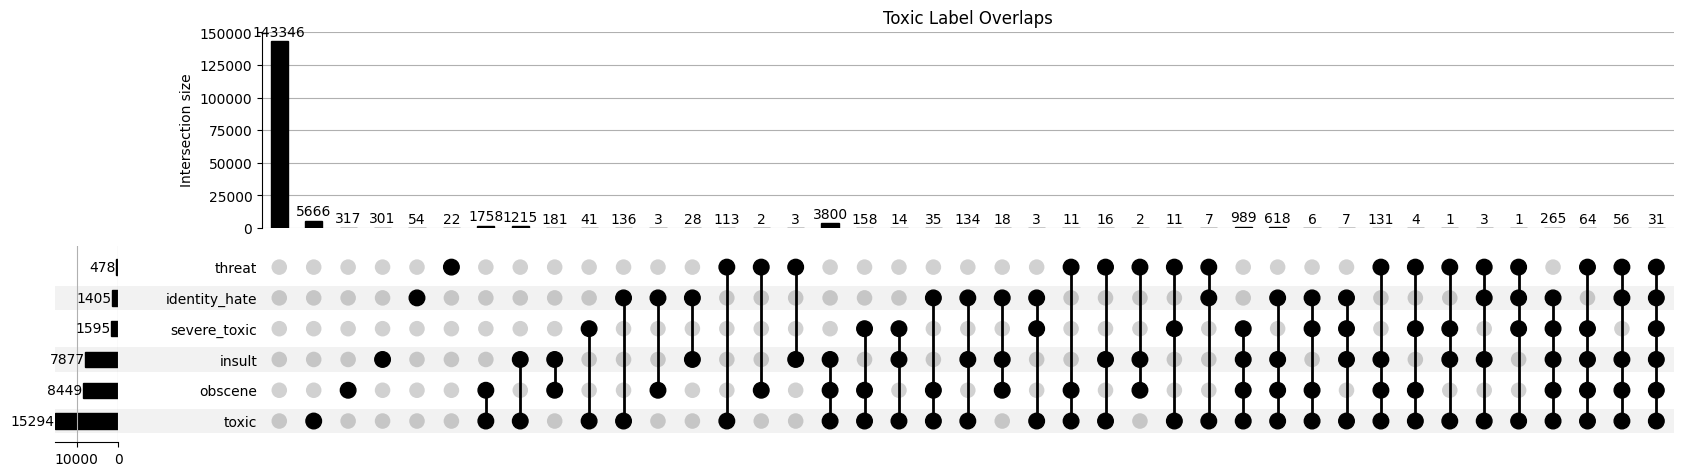

In [14]:
from upsetplot import UpSet, from_indicators

boolean_df = train[label_cols].astype(bool)


data_for_upset = from_indicators(label_cols, boolean_df)

plt.figure(figsize=(12, 6))
UpSet(data_for_upset, subset_size='count', show_counts=True).plot()
plt.title('Toxic Label Overlaps')
plt.show()

* I just wanted to see the combinations of the labels where we observed it in correlation matrix.
* code: https://upsetplot.readthedocs.io/en/stable/

In [15]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
num_labels       0
dtype: int64

####  Good sign is there is no missing values!!

Text feature statistics:
       text_length  word_count  sentence_count  exclamation_count  \
count    159571.00   159571.00       159571.00          159571.00   
mean        394.07       67.27            5.26               0.66   
std         590.72       99.23            7.20              25.90   
min           6.00        1.00            1.00               0.00   
25%          96.00       17.00            2.00               0.00   
50%         205.00       36.00            4.00               0.00   
75%         435.00       75.00            6.00               0.00   
max        5000.00     1411.00          683.00            4942.00   

       question_count  uppercase_ratio  
count       159571.00        159571.00  
mean             0.45             0.05  
std              1.59             0.09  
min              0.00             0.00  
25%              0.00             0.02  
50%              0.00             0.03  
75%              1.00             0.05  
max            209.00    

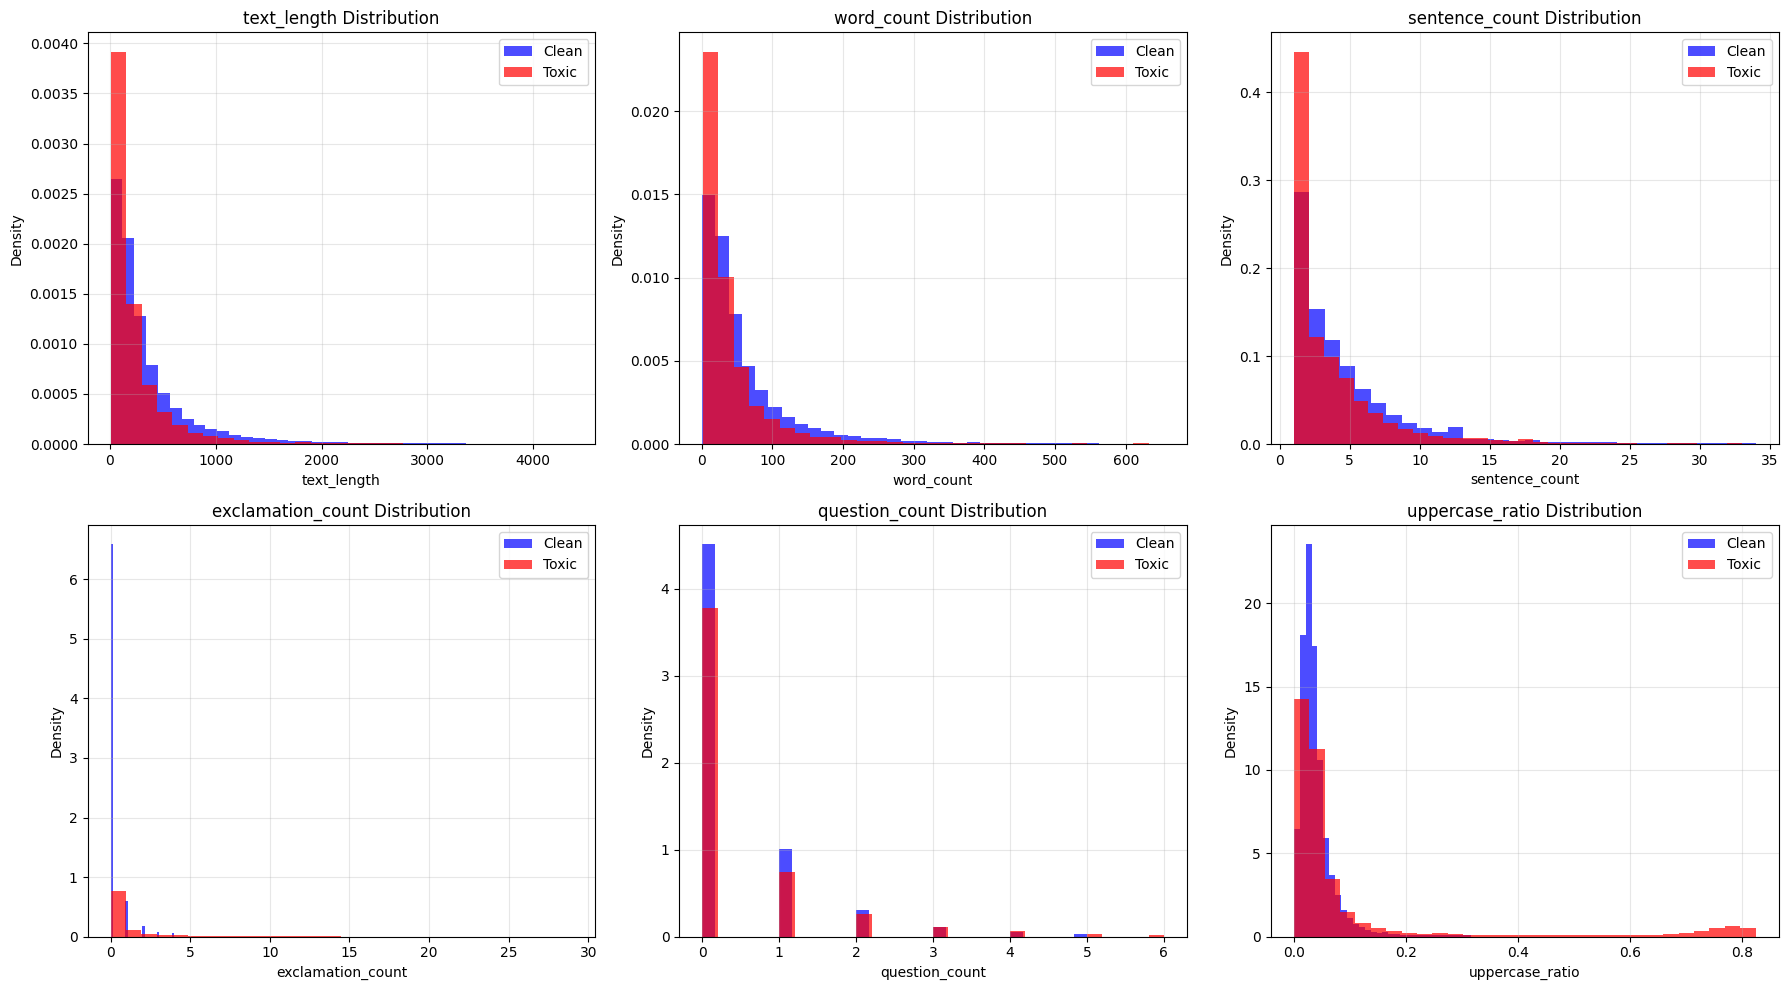

In [16]:
def analyze_text_features(df):
    
    #text features
    df['text_length'] = df['comment_text'].str.len()
    df['word_count'] = df['comment_text'].str.split().str.len()
    df['sentence_count'] = df['comment_text'].str.count('\.') + 1
    df['exclamation_count'] = df['comment_text'].str.count('!')
    df['question_count'] = df['comment_text'].str.count('\?')
    df['uppercase_ratio'] = df['comment_text'].apply(
        lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
    )
    
    #statistics
    text_features = ['text_length', 'word_count', 'sentence_count', 'exclamation_count', 'question_count', 'uppercase_ratio']
    print("Text feature statistics:")
    print(df[text_features].describe().round(2))
    
    # toxic vs clean
    print("\nText features: Toxic vs Clean comparison")
    toxicity_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    df['is_any_toxic'] = (df[toxicity_cols].sum(axis=1) > 0)
    
    comparison = df.groupby('is_any_toxic')[text_features].mean()
    comparison.index = ['Clean', 'Toxic']
    print(comparison.round(2))
    
    #differences
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, feature in enumerate(text_features):
        clean_data = df[~df['is_any_toxic']][feature]
        toxic_data = df[df['is_any_toxic']][feature]
        
        # without extreme outliers for  visualization
        clean_q99 = clean_data.quantile(0.99)
        toxic_q99 = toxic_data.quantile(0.99)
        
        clean_filtered = clean_data[clean_data <= clean_q99]
        toxic_filtered = toxic_data[toxic_data <= toxic_q99]
        
        axes[i].hist(clean_filtered, bins=30, alpha=0.7, label='Clean', color='blue', density=True)
        axes[i].hist(toxic_filtered, bins=30, alpha=0.7, label='Toxic', color='red', density=True)
        axes[i].set_title(f'{feature} Distribution')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Density')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    

analyze_text_features(train)

### Conclusion

- The dataset consists of over 159k comments with 6 toxicity-related binary labels.
- The labels are imbalanced, with `toxic`, `obscene`, and `insult` being the most common.
- Exploratory analysis showed strong correlations between `toxic`, `obscene`, and `insult`, while `threat` appeared more distinct.
- Text features such as `uppercase_ratio`, `text_length`, and `exclamation_count` differ noticeably between toxic and clean comments.
- There are no missing values, and no action needed for outliers.
- For model preparation, feature scaling (especially for count-based features) may be needed depending on algorithm choice.
- Based on initial analysis, `uppercase_ratio` and `exclamation_count` might be strong signals for toxicity prediction.

Next, I will begin data preprocessing steps.

## Data Processing & Model Building

## Modeling Plan (4 Models)
* I will compare 4 model two deep learning and two ml model for performance comparision.

### 1: Word Embeddings
#### LSTM with Attention
#### CNN

### 2: TF-IDF Features
* Here with TF-IDF features I will get a result from decent ML model to show how deep learning works better compare to ML model.
#### Random Forest


In [17]:
def preprocess_text(text):

    text = text.lower()
    #remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    #remove extra whitespaces
    text = ' '.join(text.split())
    return text

* Here with this function we will remove extra spaces and speacial characters.

#### Word embeddings setup

In [19]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['comment_text'])
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(df['comment_text']), maxlen=200)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(test['comment_text']), maxlen=200)


In [20]:
y_train = df[label_cols].values
X_train, X_val, y_train_split, y_val = train_test_split(
    X_train_seq, y_train, test_size=0.1, random_state=42
)
print(f"training set shape: {X_train.shape}")
print(f"val set shape: {X_val.shape}")
print(f"Labels shape: {y_train_split.shape}")

training set shape: (143613, 200)
val set shape: (15958, 200)
Labels shape: (143613, 6)


### Building LSTM Model

In [21]:
def create_lstm_model():
    model = Sequential([
        Embedding(20000, 128, input_length=200),
        SpatialDropout1D(0.2),
        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(6, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

### Building CNN

In [22]:
def create_cnn_model():
    model = Sequential([
        Embedding(20000, 128, input_length=200),
        SpatialDropout1D(0.2),
        Conv1D(64, 5, activation='relu', padding='same'),
        GlobalMaxPooling1D(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(6, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

### Creating models

In [45]:

lstm_model = create_lstm_model()
cnn_model = create_cnn_model()
lstm_model.build(input_shape=(None, 200))
cnn_model.build(input_shape=(None, 200))
print("LSTM Model Summary:")
lstm_model.summary()
print("\n" + "="*50 + "\n")
print("CNN Model Summary:")
cnn_model.summary()

LSTM Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 200, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 200, 128)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 200, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,611,686 (9.96 MB)

 Trainable params: 2,611,686 (9.96 MB)

 Non-trainable params: 0 (0.00 B)



CNN Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 200, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_3                  │ (None, 200, 128)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 200, 64)             │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,603,302 (9.93 MB)

 Trainable params: 2,603,302 (9.93 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Training callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

# train LSTM Model

lstm_history = lstm_model.fit(
    X_train, y_train_split,
    batch_size=128,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

# train CNN Model

print("\n" + "="*30)
cnn_history = cnn_model.fit(
    X_train, y_train_split,
    batch_size=256,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
561/561 ━━━━━━━━━━━━━━━━━━━━ 266s 474ms/step - accuracy: 0.9699 - loss: 0.0461 - val_accuracy: 0.9940 - val_loss: 0.0470 - learning_rate: 5.0000e-04
Epoch 2/5
561/561 ━━━━━━━━━━━━━━━━━━━━ 262s 467ms/step - accuracy: 0.9605 - loss: 0.0438 - val_accuracy: 0.9940 - val_loss: 0.0467 - learning_rate: 5.0000e-04
Epoch 3/5
561/561 ━━━━━━━━━━━━━━━━━━━━ 266s 475ms/step - accuracy: 0.9522 - loss: 0.0427 - val_accuracy: 0.9940 - val_loss: 0.0466 - learning_rate: 5.0000e-04
Epoch 4/5
561/561 ━━━━━━━━━━━━━━━━━━━━ 263s 470ms/step - accuracy: 0.9474 - loss: 0.0415 - val_accuracy: 0.9940 - val_loss: 0.0479 - learning_rate: 5.0000e-04
Epoch 5/5
561/561 ━━━━━━━━━━━━━━━━━━━━ 264s 471ms/step - accuracy: 0.9421 - loss: 0.0405 - val_accuracy: 0.9940 - val_loss: 0.0487 - learning_rate: 5.0000e-04

Epoch 1/5
561/561 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9654 - loss: 0.0400 - val_accuracy: 0.9940 - val_loss: 0.0465 - learning_rate: 5.0000e-04
Epoch 2/5
561/561 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/st

In [37]:
# Simple evaluation function
def evaluate_model(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    aucs = []
    for i, label in enumerate(label_cols):
        auc = roc_auc_score(y_val[:, i], y_pred[:, i])
        aucs.append(auc)
    mean_auc = np.mean(aucs)
    print(f"{model_name} Mean AUC: {mean_auc:.4f}")
    return mean_auc

# Get results
print("Evaluating models...")
lstm_auc = evaluate_model(lstm_model, X_val, y_val, "LSTM")
cnn_auc = evaluate_model(cnn_model, X_val, y_val, "CNN")


Evaluating models...
499/499 ━━━━━━━━━━━━━━━━━━━━ 53s 106ms/step
LSTM Mean AUC: 0.9764
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
CNN Mean AUC: 0.9767


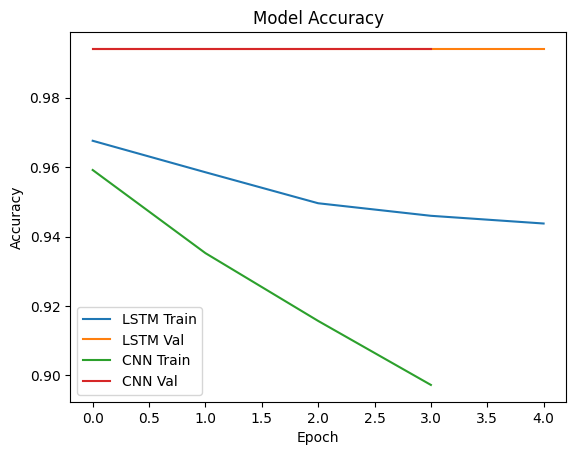

In [38]:

plt.plot(lstm_history.history['accuracy'], label='LSTM Train')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val')
plt.plot(cnn_history.history['accuracy'], label='CNN Train')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

Based on our results LSTM model is performing better, but in both model validation accuracy is not changing it might be due model is already complex for this task or we dont have enought validation data.

## Hyperparameter Tuning


previous LSTM model
AUC: 0.9767

Bigger LSTM
   AUC: 0.9775

Lower LR
   AUC: 0.9754

RESULTS:
Original LSTM  : 0.9767
Bigger LSTM    : 0.9775
Lower LR LSTM  : 0.9754

🏆 Best: Bigger LSTM with 0.9775 AUC


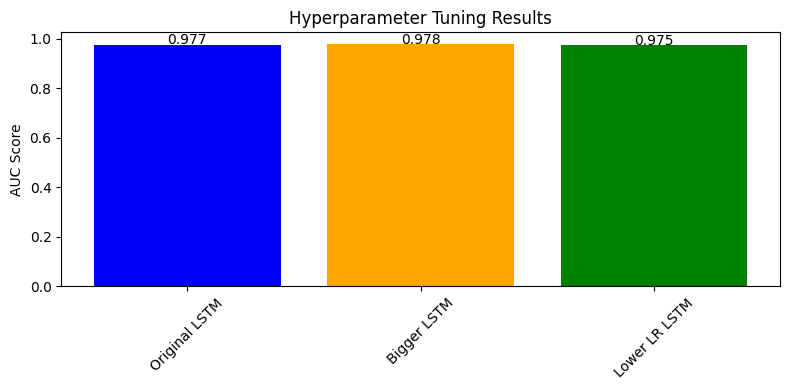


Using Bigger LSTM for final submission
submission...
4787/4787 ━━━━━━━━━━━━━━━━━━━━ 253s 53ms/step

📊 Summary:
• Tested 3 configurations
• Best: Bigger LSTM
• Final AUC: 0.9775
• Ready for Kaggle! 🚀


In [55]:
from sklearn.metrics import roc_auc_score

# auc performance comparision!
def check_auc(model, X_val, y_val):
    y_pred = model.predict(X_val, verbose=0)
    aucs = []
    for i in range(6):
        auc = roc_auc_score(y_val[:, i], y_pred[:, i])
        aucs.append(auc)
    return np.mean(aucs)


print("\nprevious LSTM model")
original_auc = check_auc(lstm_model, X_val, y_val)
print(f"AUC: {original_auc:.4f}")

#bigger lstm model- I am testing bigger model.
print("\nBigger LSTM")
bigger_lstm = Sequential([
    Embedding(20000, 246, input_length=200),
    SpatialDropout1D(0.2),
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),  #32->64
    Dropout(0.3),
    Dense(6, activation='sigmoid')
])

bigger_lstm.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

bigger_lstm.fit(X_train, y_train_split, batch_size=128, epochs=5, 
                validation_data=(X_val, y_val), verbose=0)

bigger_auc = check_auc(bigger_lstm, X_val, y_val)
print(f"   AUC: {bigger_auc:.4f}")

# testing lower learning rate
print("\nLower LR")
lr_lstm = Sequential([
    Embedding(20000, 128, input_length=200),
    SpatialDropout1D(0.2),
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='sigmoid')
])

lr_lstm.compile(optimizer=Adam(0.0005), loss='binary_crossentropy', metrics=['accuracy'])  # 0.001 -> 0.0005

lr_lstm.fit(X_train, y_train_split, batch_size=128, epochs=5, 
            validation_data=(X_val, y_val), verbose=0)

lr_auc = check_auc(lr_lstm, X_val, y_val)
print(f"   AUC: {lr_auc:.4f}")

#comparison
print("\n" + "="*40)
print("RESULTS:")
results = [
    ("Original LSTM", original_auc),
    ("Bigger LSTM", bigger_auc),
    ("Lower LR LSTM", lr_auc)
]

for name, auc in results:
    print(f"{name:15s}: {auc:.4f}")

# get the best
best_name, best_auc = max(results, key=lambda x: x[1])
print(f"\nBest: {best_name} with {best_auc:.4f} AUC")

# visualization
plt.figure(figsize=(8, 4))

#results
names = [r[0] for r in results]
aucs = [r[1] for r in results]

plt.bar(names, aucs, color=['blue', 'orange', 'green'])
plt.title('Hyperparameter Tuning Results')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)

for i, v in enumerate(aucs):
    plt.text(i, v + 0.001, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# use best model for submission
if best_name == "Bigger LSTM":
    final_model = bigger_lstm
elif best_name == "Lower LR LSTM":
    final_model = lr_lstm
else:
    final_model = lstm_model

print(f"\nUsing {best_name} for final submission")

# submission
print("submission...")
predictions = final_model.predict(X_test_seq)
submission = pd.DataFrame({'id': test['id']})
for i, col in enumerate(label_cols):
    submission[col] = predictions[:, i]

submission.to_csv('final_submission.csv', index=False)


print(f"\nSummary:")
print(f"• Best: {best_name}")
print(f"• Final AUC: {best_auc:.4f}")


### Hyperparameter Tuning Observations

#### 1. Bigger Network Effect
- **Improvement:** 0.9775 AUC vs 0.9767 (baseline) - only +0.0008 improvement
- **Insight:** This small improvement suggests the dataset isn't complex enough to benefit significantly from deeper models
- The original model was already capturing most patterns - diminishing returns from added complexity

#### 2. Learning Rate Effect  
- **Result:** Lower LR (0.0005) performed worse than original (0.001)
- **Why:** Model learned too slowly in the given epochs
- **Conclusion:** Original learning rate was already well-tuned for this dataset

#### 3. Key Insights
- **Winner:** Bigger LSTM, but improvement is marginal (+0.08%)
- **Reality Check:** All models achieved >97.6% AUC - differences are tiny
- **Dataset Characteristic:** This toxic comment dataset may not require very complex architectures

#### 4. Next Steps
- Small improvements suggest we're hitting a performance ceiling with deep learning
- **Hypothesis:** Traditional ML models might perform similarly with much less complexity
- Worth testing simpler approaches (Logistic Regression, Random Forest) for comparison

#### 5. Performance Summary
- Best: Bigger LSTM (0.9775 AUC)
- Gap between models: <0.002 AUC  
- **Learning:** Sometimes simple baselines are hard to beat!